# Named Entity Recognition(NER) with Bi-LSTM

Named-entity recognition (NER) is a subtask of information extraction to identify pre-defined named entities such as organizations, persons, locations, etc from unstructured texts. It is also known as entity identification, entity chunking and entity extraction in some refrences.

The real world applications of NER are aimed at understanding what a text is about. Some exmaples of such application would be categorizing tickets in customer support, analyze resumes and customer feedback or even extracting information from emails and initiate accounting processes accordingly. 

In this project, Bidirectional LSTM algorithm is utilized to learn and recognize entities in sentences based on previous seen examples.





## The Data

There are many ner_dataset.csv data sets on Kaggl. We will be using a subset of the ner_dataset.csv DataSet obtained from Kaggle: 

https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus?select=ner_dataset.csv

The data consist of Sentence, Word, POS and Tag as you can see below.

Let’s explore the data using Panda.


In [12]:
import pandas as pd
data = pd.read_csv('data/ner_dataset.csv', encoding= 'latin1')

# Fill NA
data = data.fillna(method='ffill', axis=0)# Groupby and collect columns
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


## IOB Format

The IOB format, stands for for inside, outside, beginning, is a common tagging format used in named-entity recognition tasks. There are 8 main types of named entities:

<b>geo : Geographical Entity</b> 

<b>org : Organization</b> 

<b>per : Person</b> 

<b>gpe : Geopolitical Entity</b> 

<b>tim : Time indicator</b> 

<b>art : Artifact</b> 

<b>eve : Event</b> 

<b>nat : Natural Phenomenon</b> 


The above tag entities are accoumpanied by following two prefixes before a tag which indicate:

<b>B: Beginning of a chunk</b> 

<b>I: Inside a chunk</b> 


Please note that **tag 'O' indicates Outside any chunk** which means that a token belongs to no entity/chunk.



## POS — Parts of Speech Tags

Part-of-speech tagging (POS tagging or PoS tagging or POST), also called grammatical tagging is the process of marking up a word in a text (corpus) as corresponding to a particular part of speech.

# Data Pre-Processing

Let's create a list, words to populate the list of unique “Word” values in the dataset. The sentences will be padded later. So, an empty word, called “ENDPAD” will be added at the end of the list.

In [77]:
words = list(set(data['Word'].values))
words.append('ENDPAD')

total number of unique words in the dataset:

In [21]:
n_words = len(words); n_words

35179

We also need to create a list for the unique tags for the values of “Tag”. 

In [23]:
tags = list(set(data['Tag'].values))
n_tags = len(tags); n_tags

17

There are a total of 17 tags in dataset consists of 8 main tags with prefixes of 'B-' and 'I-" and also the tag 'O' indicating words that do not belong to any of the entities:

In [79]:
tags

['B-tim',
 'I-art',
 'B-geo',
 'I-per',
 'B-eve',
 'B-nat',
 'B-per',
 'O',
 'B-art',
 'B-gpe',
 'I-tim',
 'I-eve',
 'I-nat',
 'I-org',
 'B-org',
 'I-gpe',
 'I-geo']

We used SentenceGetter class to retrieve sentences with their words, POS and tags from the datasets. The code is taken from: https://www.depends-on-the-definition.com/named-entity-recognition-conditional-random-fields-python/.

In [26]:

class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [80]:
getter = SentenceGetter(data)
sentences = getter.sentences
len(sentences)

47959

There are a total of 47,959 sentences in the ner_dataset.csv which contains 35,178 different words and tagged by 17 tags.

The result of SentenceGetter().sentences looks the following. We save it in variable sentences for further processing.

In [81]:
sentences[:2]

[[('Thousands', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('demonstrators', 'NNS', 'O'),
  ('have', 'VBP', 'O'),
  ('marched', 'VBN', 'O'),
  ('through', 'IN', 'O'),
  ('London', 'NNP', 'B-geo'),
  ('to', 'TO', 'O'),
  ('protest', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('war', 'NN', 'O'),
  ('in', 'IN', 'O'),
  ('Iraq', 'NNP', 'B-geo'),
  ('and', 'CC', 'O'),
  ('demand', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('withdrawal', 'NN', 'O'),
  ('of', 'IN', 'O'),
  ('British', 'JJ', 'B-gpe'),
  ('troops', 'NNS', 'O'),
  ('from', 'IN', 'O'),
  ('that', 'DT', 'O'),
  ('country', 'NN', 'O'),
  ('.', '.', 'O')],
 [('Iranian', 'JJ', 'B-gpe'),
  ('officials', 'NNS', 'O'),
  ('say', 'VBP', 'O'),
  ('they', 'PRP', 'O'),
  ('expect', 'VBP', 'O'),
  ('to', 'TO', 'O'),
  ('get', 'VB', 'O'),
  ('access', 'NN', 'O'),
  ('to', 'TO', 'O'),
  ('sealed', 'JJ', 'O'),
  ('sensitive', 'JJ', 'O'),
  ('parts', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('the', 'DT', 'O'),
  ('plant', 'NN', 'O'),
  ('Wednesday', 'NNP', 'B-tim'),
  ('

## Features Extraction

Let's create the following helpers for the features extraction tasks:

**word2idx: convert word to index**

**tag2idx: convert tag to index**

**idx2word: convert index to word**

**idx2tag: convert index to tag**

In [36]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

idx2word = {i: w for w, i in word2idx.items()}
idx2tag = {i: w for w, i in tag2idx.items()}

In [117]:
print(word2idx['London'])
print(tag2idx['O'])

18530
7


In [118]:
print(idx2word[18530])
print(idx2tag[7])

London
O


We need to convert the every word in each sentences to their equivalent numbers to conduct learning process:

In [82]:
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [83]:
print(X[0])

[20386, 21366, 21142, 10365, 30552, 21474, 18530, 17253, 17188, 22844, 11615, 18833, 6161, 16279, 28906, 22844, 25641, 21366, 27598, 6952, 8273, 9561, 16545, 24167]


In [84]:
print(' '.join((idx2word[idx] for idx in X[0])))

Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .


We need to perform padding on the sentences to the same length (max_len = 50) and fill with index value of “ENDPAD” or 35178.

In [55]:
max_len = 50
from keras.preprocessing.sequence import pad_sequences

# value = n-words-1 which is 'ENDPAD'or index 35178
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)

Accordingly, the same thing needs to be done for Labels: getting ocnverted to numbers followed by the padding process.

In [56]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

And then we padding the Labels to the same length (max_len = 50) and fill with index value of entity “O — Outside any chunk” or 11.

In [57]:
# value = 11 (O - Outside any chunk)
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx['O'])

And finally we perform one-hot encoding to labels.

In [59]:
from tensorflow.keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

## Split Train and Test Sets

Using train_test_split from sklearn, we split X (sentences)and y (labels) to train sets and test sets.

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [62]:
X_train.shape, X_test.shape

((43163, 50), (4796, 50))

## Build and Compile Model

We create and compile the sequential model with the following architecture.

In [68]:
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import tensorflow as tf

input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
model = Dropout(0.5)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

model = Model(input, out)

opt = tf.keras.optimizers.Adam(lr=0.01, decay=1e-6)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"]) 

C:\Users\mhoss\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


We use optimizer Adam and loss function categorical_crossentropy. Here is the model.summary() result:

In [69]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


## Training

And we run training for 10 epochs by calling model.fit().

In [71]:
import numpy as np

history = model.fit(X_train, np.array(y_train), 
                    batch_size=32, 
                    epochs=10, 
                    validation_split=0.2,
                    verbose=1)

Epoch 1/10
1080/1080 [==============================] - 122s 109ms/step - loss: 0.0915 - accuracy: 0.9754 - val_loss: 0.0494 - val_accuracy: 0.9853
Epoch 2/10
1080/1080 [==============================] - 106s 98ms/step - loss: 0.0446 - accuracy: 0.9864 - val_loss: 0.0472 - val_accuracy: 0.9856
Epoch 3/10
1080/1080 [==============================] - 108s 100ms/step - loss: 0.0382 - accuracy: 0.9882 - val_loss: 0.0463 - val_accuracy: 0.9863
Epoch 4/10
1080/1080 [==============================] - 109s 101ms/step - loss: 0.0358 - accuracy: 0.9888 - val_loss: 0.0466 - val_accuracy: 0.9862
Epoch 5/10
1080/1080 [==============================] - 5077s 5s/step - loss: 0.0343 - accuracy: 0.9892 - val_loss: 0.0476 - val_accuracy: 0.9861
Epoch 6/10
1080/1080 [==============================] - 112s 104ms/step - loss: 0.0335 - accuracy: 0.9894 - val_loss: 0.0482 - val_accuracy: 0.9858
Epoch 7/10
1080/1080 [==============================] - 107s 99ms/step - loss: 0.0323 - accuracy: 0.9897 - val_loss

## Plot Accuracy and Loss

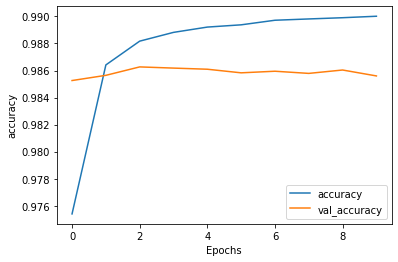

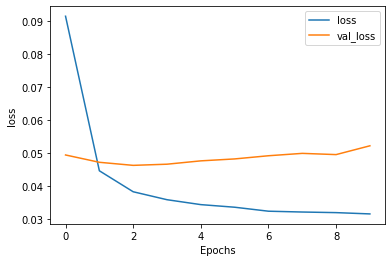

In [73]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Prediction

Let’s try with the prediction and see if it can predict correctly.

In [132]:
i = np.random.randint(0, X_test.shape[0])
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:5}\t {}\n".format("Word","True","Pred"))
print("-"*30)
for w,true,pred in zip(X_test[i], y_true, p[0]):
  print("{:15}{:5}\t{}".format(words[w], tags[true],tags[pred]))

Word           True 	 Pred

------------------------------
Police         O    	O
say            O    	O
Abdul          B-per	B-per
Samad          I-per	I-per
Achakzai       I-per	I-per
and            O    	O
his            O    	O
bodyguard      O    	O
were           O    	O
killed         O    	O
when           O    	O
gunmen         O    	O
fired          O    	O
on             O    	O
their          O    	O
car            O    	O
as             O    	O
it             O    	O
drove          O    	O
through        O    	O
Kojak          B-geo	O
pass           O    	O
,              O    	O
northwest      O    	O
of             O    	O
Quetta         B-geo	B-geo
,              O    	O
the            O    	O
capital        O    	O
of             O    	O
Baluchistan    B-geo	B-geo
province       O    	O
.              O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
E

here is a piece of code that will highlight the entities in any given sentence using spaCy.

In [138]:
import spacy
import en_core_web_sm
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
text = nlp('Jim bought 300 shares of Acme Corp. in 2006. And producing an annotated block of text that highlights the names of entities: Jim bought 300 shares of Acme Corp. in 2006. In this example, a person name consisting of one token, a two-token company name and a temporal expression have been detected and classified.State-of-the-art NER systems for English produce near-human performance. For example, the best system entering MUC-7 scored 93.39% of F-measure while human annotators scored 97.60% and 96.95%.[1][2]')
displacy.render(text, style = 'ent', jupyter=True)